# Loan Default Prediction in the Fannie Mae Single Family Loan Dataset

## 1. Introduction

What is Fannie Mae? According to Wikipedia, "The Federal National Mortgage Association (FNMA), commonly known as Fannie Mae, is a United States government-sponsored enterprise (GSE) and, since 1968, a publicly traded company. Founded in 1938 during the Great Depression as part of the New Deal, the corporation's purpose is to expand the secondary mortgage market by securitizing mortgages in the form of mortgage-backed securities (MBS), allowing lenders to reinvest their assets into more lending and in effect increasing the number of lenders in the mortgage market by reducing the reliance on locally based savings and loan associations." Fannie Mae releases quarterly based single family fixed rate mortgage dataset on its website. The data is divided into acquisition files and performance files grouped quarterly ranging from year 2000 to 2017. The acquisition files contain static mortgage loan data at the time of the mortgage loan's origination and delivery to Fannie Mae, these files include personal information, loan amount, loan rate and other things. The performance files contain monthly performance data for each loan such as payment information, from acquisition up until its current status as of the previous quarter. Inspired by Kyle's notebook [see here](https://degravek.github.io/project-pages/project1/2016/11/12/New-Notebook/), we can utilize the existance of the last status of each loan to determine whether a loan is bad, In this project, I am interested if we can use machine learning techniques to predict whether a loan will end as a default by the time we just know the origination.I am going to explore the third quarter data of 2007 and make a model, see if I can use this model to forecast the defaulted loan on the fourth quarter of 2007, which has the highest delinquency rate in the agency’s history – 19.4% versus the historical average of 1.7%.    

## 2. The Definition of Default

I don't find any description about Fannie Mae's official definition on the defaulted mortgage loan. But I've reviewed the codes of tutorial 101 provived by Fannie Mae, the Default UPB was calculated by a summation of the loans which has a zero balance code 
<br>
<br>
02 - Thrid Party 
<br>
03 - Short Sale
<br>
09 - Deed-in-Lieu REO Disposition
<br>
15 - Note Sale
<br>
<br>
and the disposition date is not null. We can just use these four ZB codes to label the defaulted loan.

## 3. Import and Clean the Dataset

Let's import the Python packages that need to be used in this project. 

In [80]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,auc,average_precision_score,accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np
from ggplot import *
import xgboost as xgb
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("max_colwidth",1000000)
pd.set_option('max_columns', 50)

First, I will import the data set Acquisition_2007Q3.txt and Performance_2007Q3.txt. The performance data set contains 18 million records, accually we're just interested on the last record of each loan that shows the latest loan status. So I will drop those duplicate records then join the two data sets by the Loan_id. To save more time, I recommend saving the combined data set for the future use as the import process could take an hour thereby I don't need to load it everytime I re-open the notebook.

Acquisitions_Variables =["LOAN_ID", "ORIG_CHN", "Seller.Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE"
                           ,"FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", "PROP_TYP"
                           ,"NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", "RELOCATION_FLG"]

Performance_Variables = ["LOAN_ID", "Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat"
                          , "Adj.Month.To.Mat", "Maturity.Date", "MSA", "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
                          "ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", "TAX_COST", "NS_PROCS",
                          "CE_PROCS", "RMW_PROCS", "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"]

Acquisitions_ColClasses = ["str", "str", "str", "float", "float", "int", "str", "str", "float",
                            "float", "str", "float", "float", "str", "str", "str", "str", "str",
                            "str", "str", "float", "str", "float", "float", "str"]

Performance_ColClasses = ["str", "str", "str", "float", "float", "float", "float", "float", "str",
                            "str", "str", "str", "str", "str", "str", "str", "str",
                            "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "str", "float", "str"]

Acquisitions_dict=dict(zip(Acquisitions_Variables,Acquisitions_ColClasses))
Performance_dict=dict(zip(Performance_Variables,Performance_ColClasses))
#Combined_date_cols=["ORIG_DTE","FRST_DTE","Maturity.Date","ZB_DTE", "LPI_DTE","FCC_DTE"]

Data_A= pd.read_csv('Acquisition_2007Q3.txt', sep='|', 
                    names=Acquisitions_Variables,
                    dtype=Acquisitions_dict,
                    parse_dates=["ORIG_DTE","FRST_DTE"],
                    index_col=False)
Data_P = pd.read_csv('Performance_2007Q3.txt', sep='|', 
                     names=Performance_Variables, 
                     dtype=Performance_dict,
                     parse_dates=["Maturity.Date","ZB_DTE", "LPI_DTE","FCC_DTE"],
                     index_col=False)


Data_P.drop_duplicates(subset='LOAN_ID', keep='last', inplace=True)
Combined_Data = pd.merge(Data_A, Data_P, on='LOAN_ID', how='inner')

Combined_Data.to_csv("Combined_Data_2007Q3.txt",sep='|',index=False,header=False)

Let's read the Combined_Data_2007Q3.txt again assumed you've open a new notebook. This time we can exclude some variables originally from the performance data set which are not relevant to origination and the loan result. I only import Delq.Status, DISP_DT, Zero.Bal.Code (ZB) from the performance data set. The Combined_Data has 314603 loans and 24 variables.

In [85]:
Combined_Variables =["LOAN_ID", "ORIG_CHN", "Seller.Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE"
                            ,"FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", "PROP_TYP"
                            ,"NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", "RELOCATION_FLG"
                            
                     , "Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat"
                            , "Adj.Month.To.Mat", "Maturity.Date", "MSA", "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
                            "ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", "TAX_COST", "NS_PROCS",
                            "CE_PROCS", "RMW_PROCS", "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"]

Combined_ColClasses = ["str", "str", "str", "float", "float", "int", "str", "str", "float",
                            "float", "str", "float", "float", "str", "str", "str", "str", "str",
                            "str", "str", "float", "str", "float", "float", "str"

                       , "str", "str", "float", "float", "float", "float", "float", "str",
                            "str", "str", "str", "str", "str", "str", "str", "str",
                            "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "str", "float", "str"]

Combined_dict=dict(zip(Combined_Variables,Combined_ColClasses))
#Combined_date_cols=["ORIG_DTE","FRST_DTE","Maturity.Date","ZB_DTE", "LPI_DTE","FCC_DTE"]
Combined_date_cols=["ORIG_DTE","FRST_DTE"]

Combined_Data= pd.read_csv('Combined_Data_2007Q3.txt', sep='|', 
                    names=Combined_Variables, 
                     dtype=Combined_dict,
                     parse_dates=Combined_date_cols,
                     usecols=list(range(25))+[34,36,40],     
                    index_col=False)


In [87]:
Combined_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314723 entries, 0 to 314722
Data columns (total 30 columns):
LOAN_ID           314723 non-null object
ORIG_CHN          314723 non-null object
Seller.Name       314723 non-null object
ORIG_RT           314723 non-null float64
ORIG_AMT          314723 non-null float64
ORIG_TRM          314723 non-null int32
ORIG_DTE          314723 non-null datetime64[ns]
FRST_DTE          314723 non-null datetime64[ns]
OLTV              314723 non-null float64
OCLTV             314723 non-null float64
NUM_BO            314713 non-null object
DTI               305580 non-null float64
CSCORE_B          314084 non-null float64
FTHB_FLG          314723 non-null object
PURPOSE           314723 non-null object
PROP_TYP          314723 non-null object
NUM_UNIT          314723 non-null object
OCC_STAT          314723 non-null object
STATE             314723 non-null object
ZIP_3             314723 non-null object
MI_PCT            55596 non-null float64
Product

### 3.1 Cleaning the Columns

Let's create some calculated variables according to Fannie Mae's tutorial. ORIG_VAL is the original home value, which can be easily calulated from the original loan amount and the original loan-to-value. I also create the OCLTV and combine the borrower credit scoreas and the co-borrower credit score into the minimum credit score CSCORE_MN, the calculation is referred to Fannie Mae's tutorial. 

In [86]:
Combined_Data['ORIG_VAL']=Combined_Data['ORIG_AMT']/(Combined_Data['OLTV']/100)
Combined_Data['OCLTV']=Combined_Data.apply(lambda row : row['OLTV'] if row['OCLTV']==np.nan else row['OCLTV'],axis=1)

Combined_Data['CSCORE_MN']=Combined_Data.apply(lambda row : min(row['CSCORE_B'],row['CSCORE_C']) ,axis=1)

# Combined_Data['VinYr']=Combined_Data['ORIG_DTE'].dt.year
# Combined_Data['ORIG_DTE_month']=Combined_Data['ORIG_DTE'].dt.month

# Combined_Data['FRST_DTE_year']=Combined_Data['FRST_DTE'].dt.year
# Combined_Data['FRST_DTE_month']=Combined_Data['FRST_DTE'].dt.month

There is a variable ZIP_3 that contains the first 3 digit zipcode of the loan origination location. If we include this feature into the model regarding as categorical feature, we need to create tons of dummy variables to represent each zipcode. After doing some research, I found a way that we can transfer the 3 digit zipcode into numeric coordinates so that we just need two continuous variables latitude and longitude to represent the zipcodes, as well as the latitude and longitude are much better for visualization.
<br>
<br>
Let's look at the ZIP_3 column:

In [88]:
Combined_Data['ZIP_3'].value_counts(dropna=False)

606    3388
600    2799
300    2706
750    2687
852    2382
601    2375
840    2188
604    2098
770    1936
481    1916
980    1877
853    1860
080    1806
605    1719
850    1632
117    1589
301    1526
773    1487
212    1480
331    1466
787    1460
917    1432
330    1418
972    1417
774    1417
190    1372
275    1370
631    1369
334    1354
327    1348
       ... 
266       9
792       9
739       8
879       8
369       7
167       7
413       7
669       5
256       5
408       5
884       4
102       4
576       4
059       3
332       3
418       2
414       2
867       2
000       2
692       2
248       2
632       1
966       1
885       1
353       1
854       1
821       1
090       1
733       1
099       1
Name: ZIP_3, dtype: int64

I notice there are two zipcode 000 in the data set, that must be erroneous entry because 000 has not been used by USPS. And the STATE variable shows that these two records are from PR and FL, respectively, so this confirms the incorrect data. We can adjust the 000 and make them as missing values.

In [89]:
Combined_Data.loc[Combined_Data['ZIP_3']=="000",'ZIP_3']=np.nan
Combined_Data['ZIP_3']=Combined_Data['ZIP_3'].astype(str)

I create a table that maps the zipcode to the coordinates using the Python package uszipcodes, then calculate the centroid coordinates for each 3 digit zip code.I join this table with the Combined_Data.

In [90]:
# Find all zipcodes
res = search.by_coordinate(39.122229, -77.133578, radius=99999, returns=99999)

zip_list=[]
for i in res:
    zip_list.append({'Zipcode': i.Zipcode,'Latitude': i.Latitude,'Longitude':i.Longitude,'ZIP_3':i.Zipcode[:3]})

allzipcodes=pd.DataFrame.from_dict(zip_list)

all3zipcodes=allzipcodes.groupby(['ZIP_3']).mean().reset_index()


Combined_Data=pd.merge(Combined_Data,df1,on='ZIP_3', how='inner')

Now we almost finish the column cleaning. We need to drop some unused columns. MI_TYPE and MI_PCT has too many missing values, LOAN_ID and a constant Product.Type do not tell any information. We have calculated the CSCORE_MN and the coordinates, so the CSCORE_B, CSCORE_C, ZIP_3 can be removed. Futhermore, the purpose of this project is to predict the loan across quarters, so the time variables might not be useful. I am exploring for a time travelling truth, so I decide to drop ORIG_DTE and FRST_DTE. Although the exact time is not being considered, I might ignore some cycling pattern that occurs seasonly, or even quarterly, I bet it would not happen.

In [93]:
drop_acquisition=["LOAN_ID","ZIP_3","MI_TYPE","MI_PCT","CSCORE_B","CSCORE_C","Product.Type","ORIG_DTE","FRST_DTE"]
Combined_Data.drop(drop_acquisition, axis=1, inplace=True)

### 3.2 Cleaning the Rows

As I discussed previouly, the default can be identified if we filter out with the four ZB codes as well as a not null disposition date. So what about the non-defaulted loan? Are the other loans healthy? Let's take a look on the distribution of Zero Balance codes.

In [94]:
Combined_Data['Zero.Bal.Code'].value_counts(dropna=False)

01     254314
NaN     32656
09      17116
03       5809
06       2026
02       1041
16        897
15        744
Name: Zero.Bal.Code, dtype: int64

Besides the default loan's code, the 'good' codes 01, 06, 16 look like they have a current healthy loan status, but the data does not tell their final status, a good loan might lead to default if the borrower lost the income and can't pay the debt. We also notice 32656 loans without a ZB code, which means a delinquency occurs. Let's look at Delq.Status.

In [95]:
Combined_Data['Delq.Status'].value_counts(dropna=False)

X      257237
0       27433
NaN     24710
1        2274
2         789
3         464
4         314
5         173
6         121
7          93
8          92
9          85
11         64
14         49
10         46
12         45
16         40
13         37
15         31
17         29
18         24
19         22
20         19
27         17
24         15
22         14
21         14
25         13
23         12
28         11
        ...  
108         2
68          2
88          2
62          2
48          2
63          2
77          2
84          2
110         2
83          2
71          2
58          2
42          2
93          2
44          1
54          1
123         1
99          1
55          1
74          1
120         1
121         1
72          1
124         1
95          1
104         1
100         1
92          1
64          1
102         1
Name: Delq.Status, dtype: int64

In [38]:
# Combined_Data['Default']=Combined_Data['FCC_DTE'].apply(lambda x: 0 if str(x)=='NaT' else 1).astype(int)
# Combined_Data.drop(['FCC_DTE'], axis=1, inplace=True)
Combined_Data['Default']=Combined_Data.apply(lambda row : 1 if row['Zero.Bal.Code'] in ['2.0','3.0','9.0','15.0'] and str(row['DISP_DT'])!='NaT' 
                                             else (0 if row['Zero.Bal.Code'] in ['1.0','6.0','16.0'] else np.nan),axis=1)
Combined_Data['Default'].value_counts(dropna=False)

 0.0    257319
NaN      32687
 1.0     24717
Name: Default, dtype: int64

In [39]:
Combined_Data=Combined_Data[Combined_Data['Default'].notnull()]
Combined_Data['Default']=Combined_Data['Default'].astype(int)
Combined_Data.shape

(282036, 23)

In [40]:
Combined_Data.groupby(['Seller.Name',"Default"]).size()

Seller.Name                                Default
AMTRUST BANK                               0           7170
                                           1            699
BANK OF AMERICA, N.A.                      0          67990
                                           1           8528
BISHOPS GATE RESIDENTIAL MORTGAGE TRUST    0           2876
                                           1            151
CITIMORTGAGE, INC.                         0          36912
                                           1           2846
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB   0            538
                                           1             15
FIRST TENNESSEE BANK NATIONAL ASSOCIATION  0           6967
                                           1            522
FLAGSTAR CAPITAL MARKETS CORPORATION       0           7205
                                           1            924
GMAC MORTGAGE, LLC                         0          14608
                                           1     

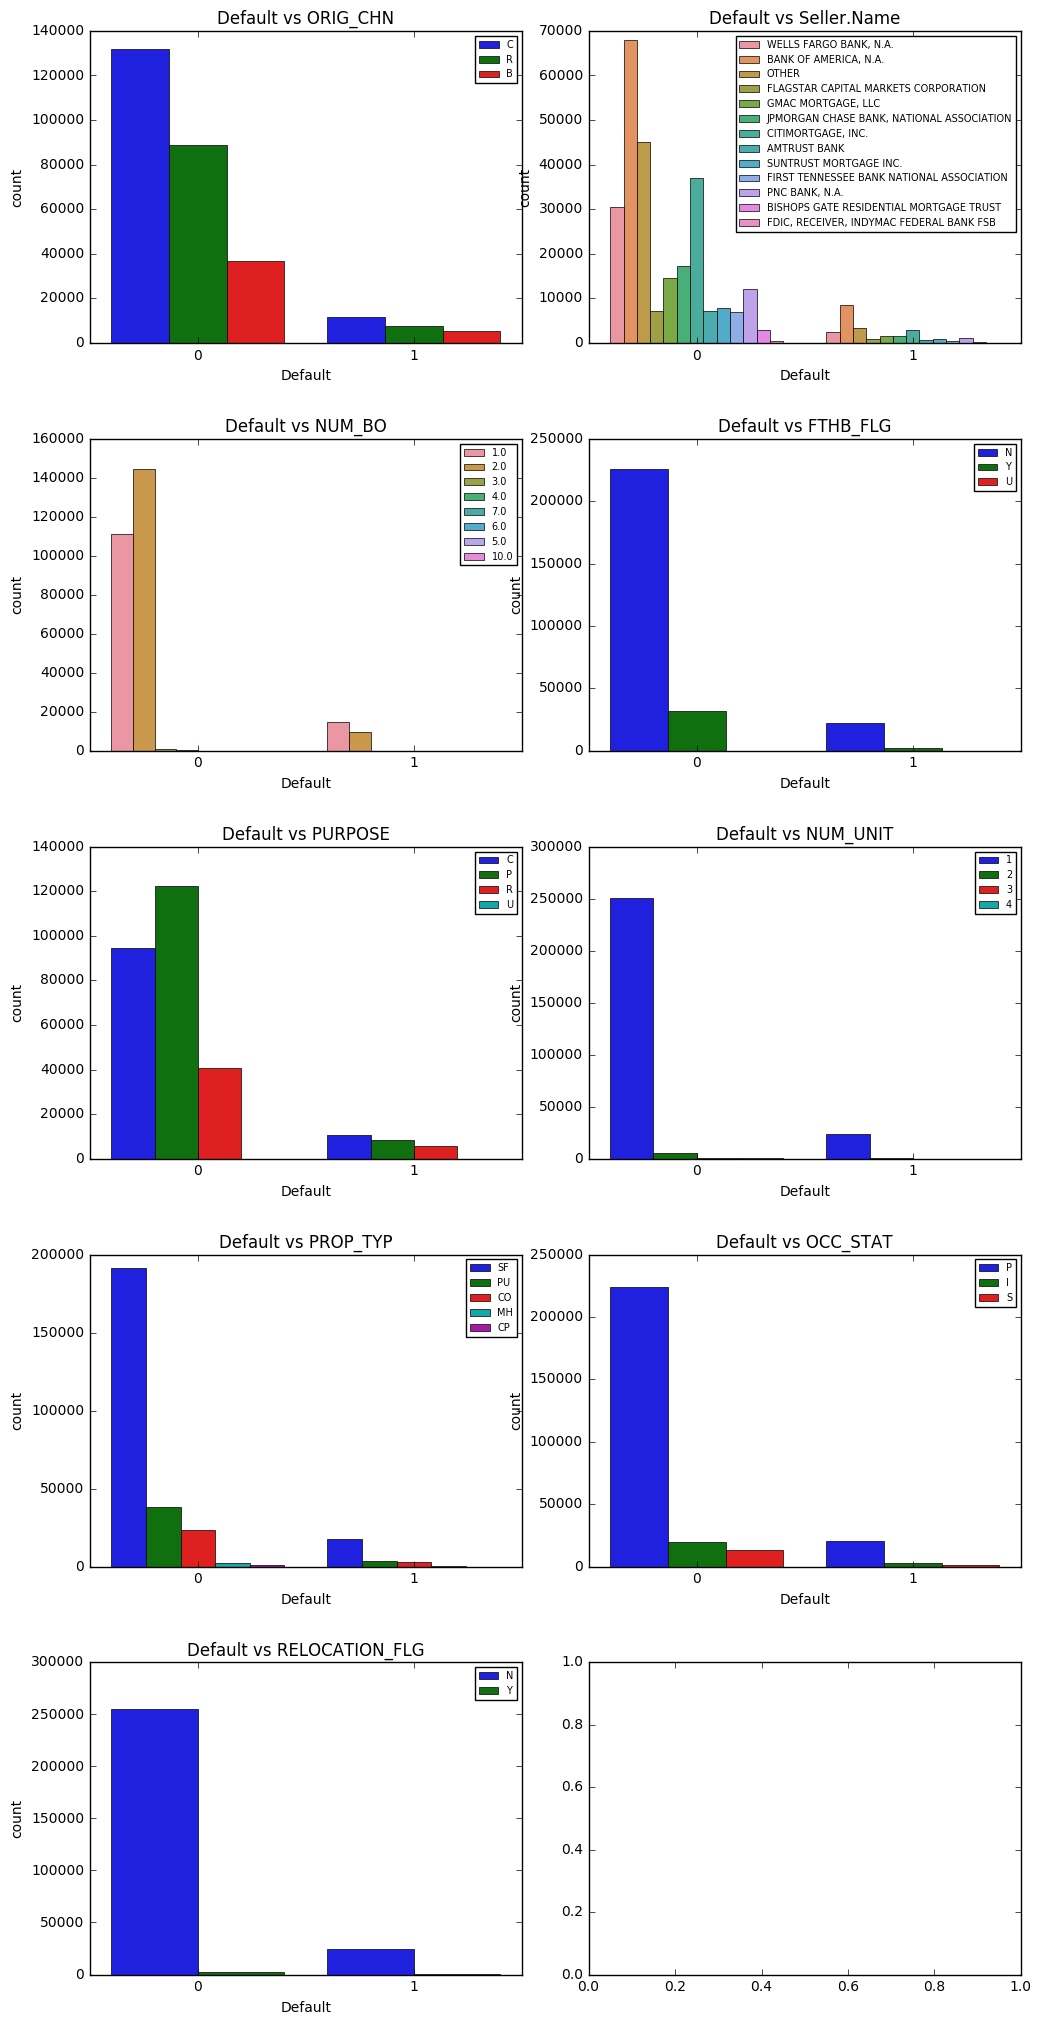

In [41]:
columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE","NUM_UNIT","PROP_TYP","OCC_STAT","RELOCATION_FLG"]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,20))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

for i, column in zip(range(1,10), columns):
    plt.subplot(5,2,i)
    ax=sns.countplot(x="Default", hue=column, data=Combined_Data, linewidth=0.5)

    ax.set_title("Default vs "+column)
    plt.legend(loc="upper right", prop={'size': 7})
    plt.xlabel('Default')
# plt.legend(loc="upper right",fontsize="xx-small")


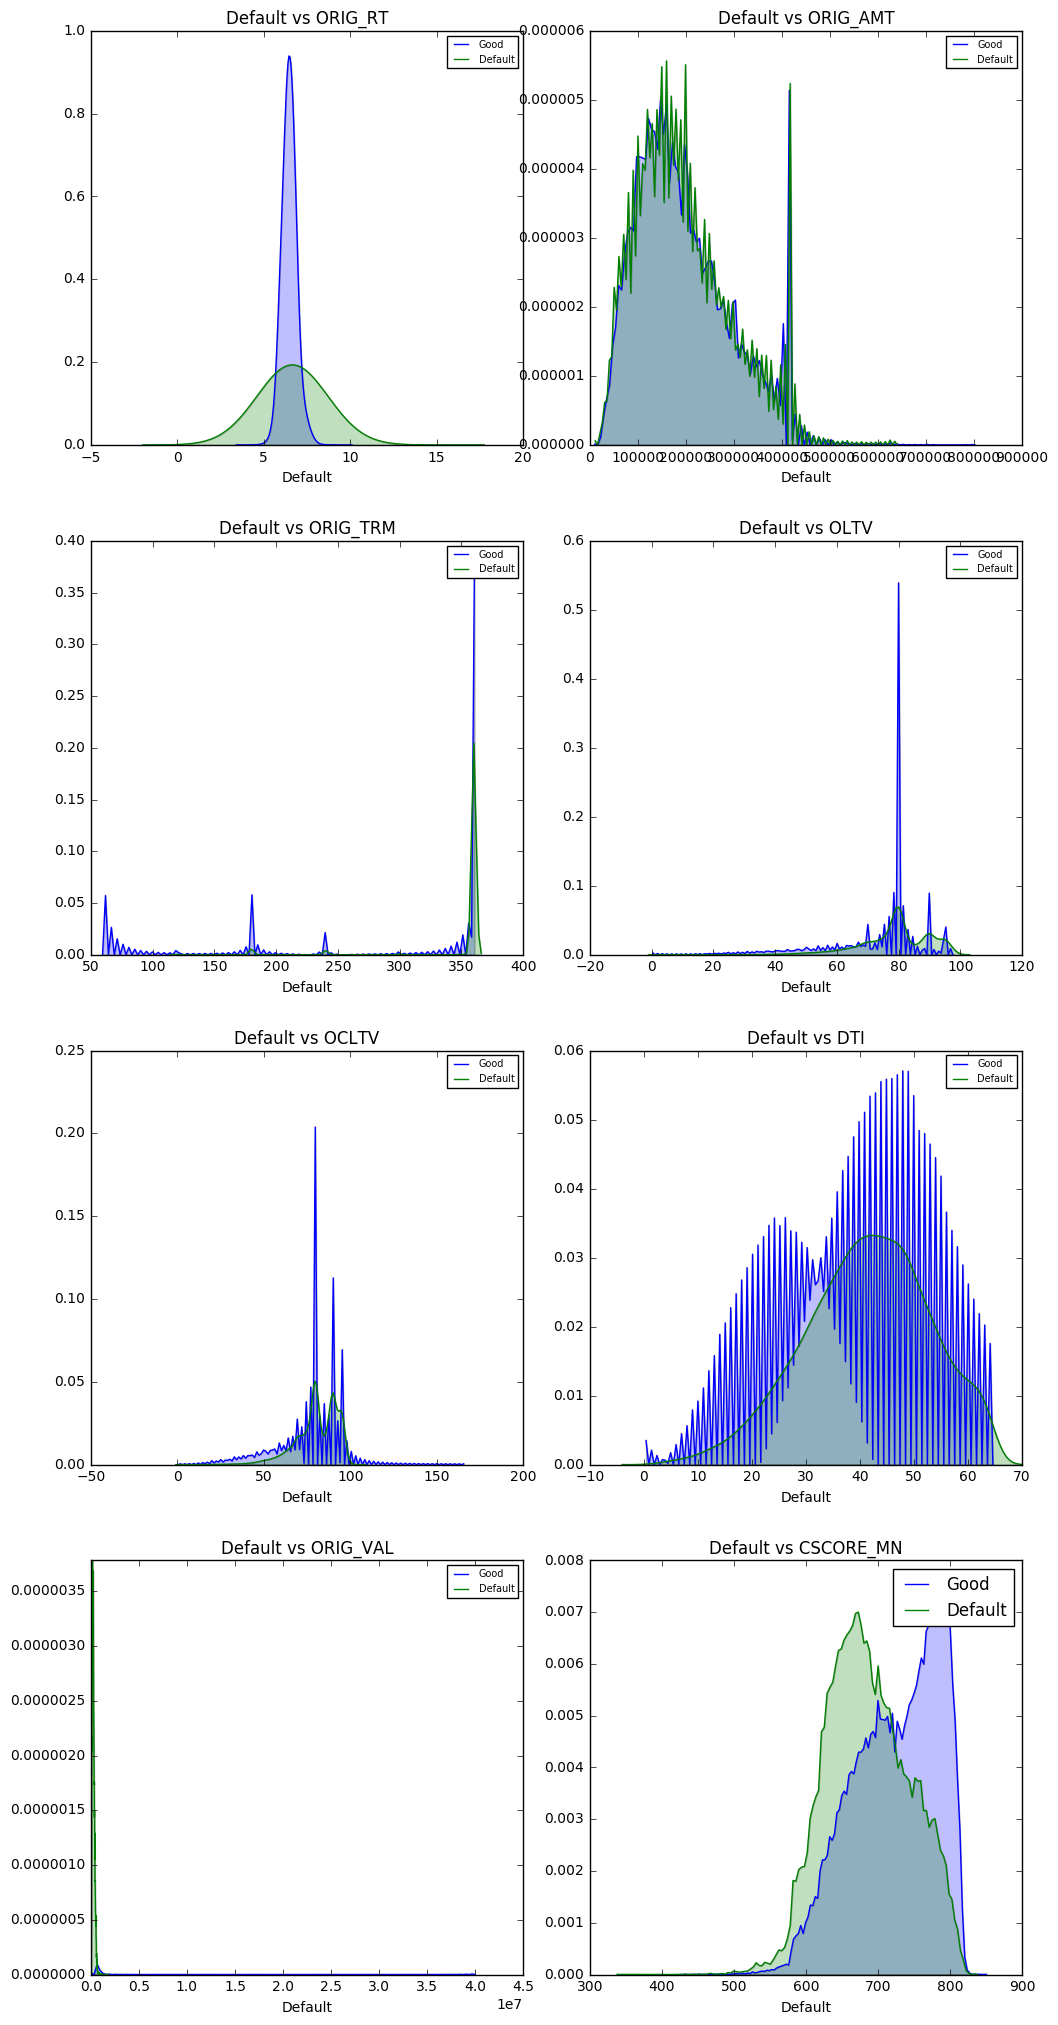

In [42]:
columns = ["ORIG_RT","ORIG_AMT","ORIG_TRM","OLTV","OCLTV","DTI","ORIG_VAL","CSCORE_MN"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,20))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

for i, column in zip(range(1,9), columns):
    plt.subplot(4,2,i)
    p1=sns.kdeplot(Combined_Data[Combined_Data['Default']==0][column], bw=.2, label="Good",shade=True)
    p2=sns.kdeplot(Combined_Data[Combined_Data['Default']==1][column], bw=2, label="Default",shade=True)

    p1.set_title("Default vs "+column)
    plt.legend(loc="upper right", prop={'size': 7})
    plt.xlabel('Default')
plt.legend()

In [43]:
Combined_Data['log_ORIG_VAL']=np.log(Combined_Data['ORIG_VAL'])
Combined_Data['log_ORIG_AMT']=np.log(Combined_Data['ORIG_AMT'])
Combined_Data['sqrt_OLTV']=np.sqrt(Combined_Data['OLTV'])
Combined_Data['log_ORIG_TRM']=-np.log(Combined_Data['ORIG_TRM'])
Combined_Data['log_OCLTV']=np.log(Combined_Data['OCLTV'])
Combined_Data['log_DTI']=np.log(Combined_Data['DTI'])

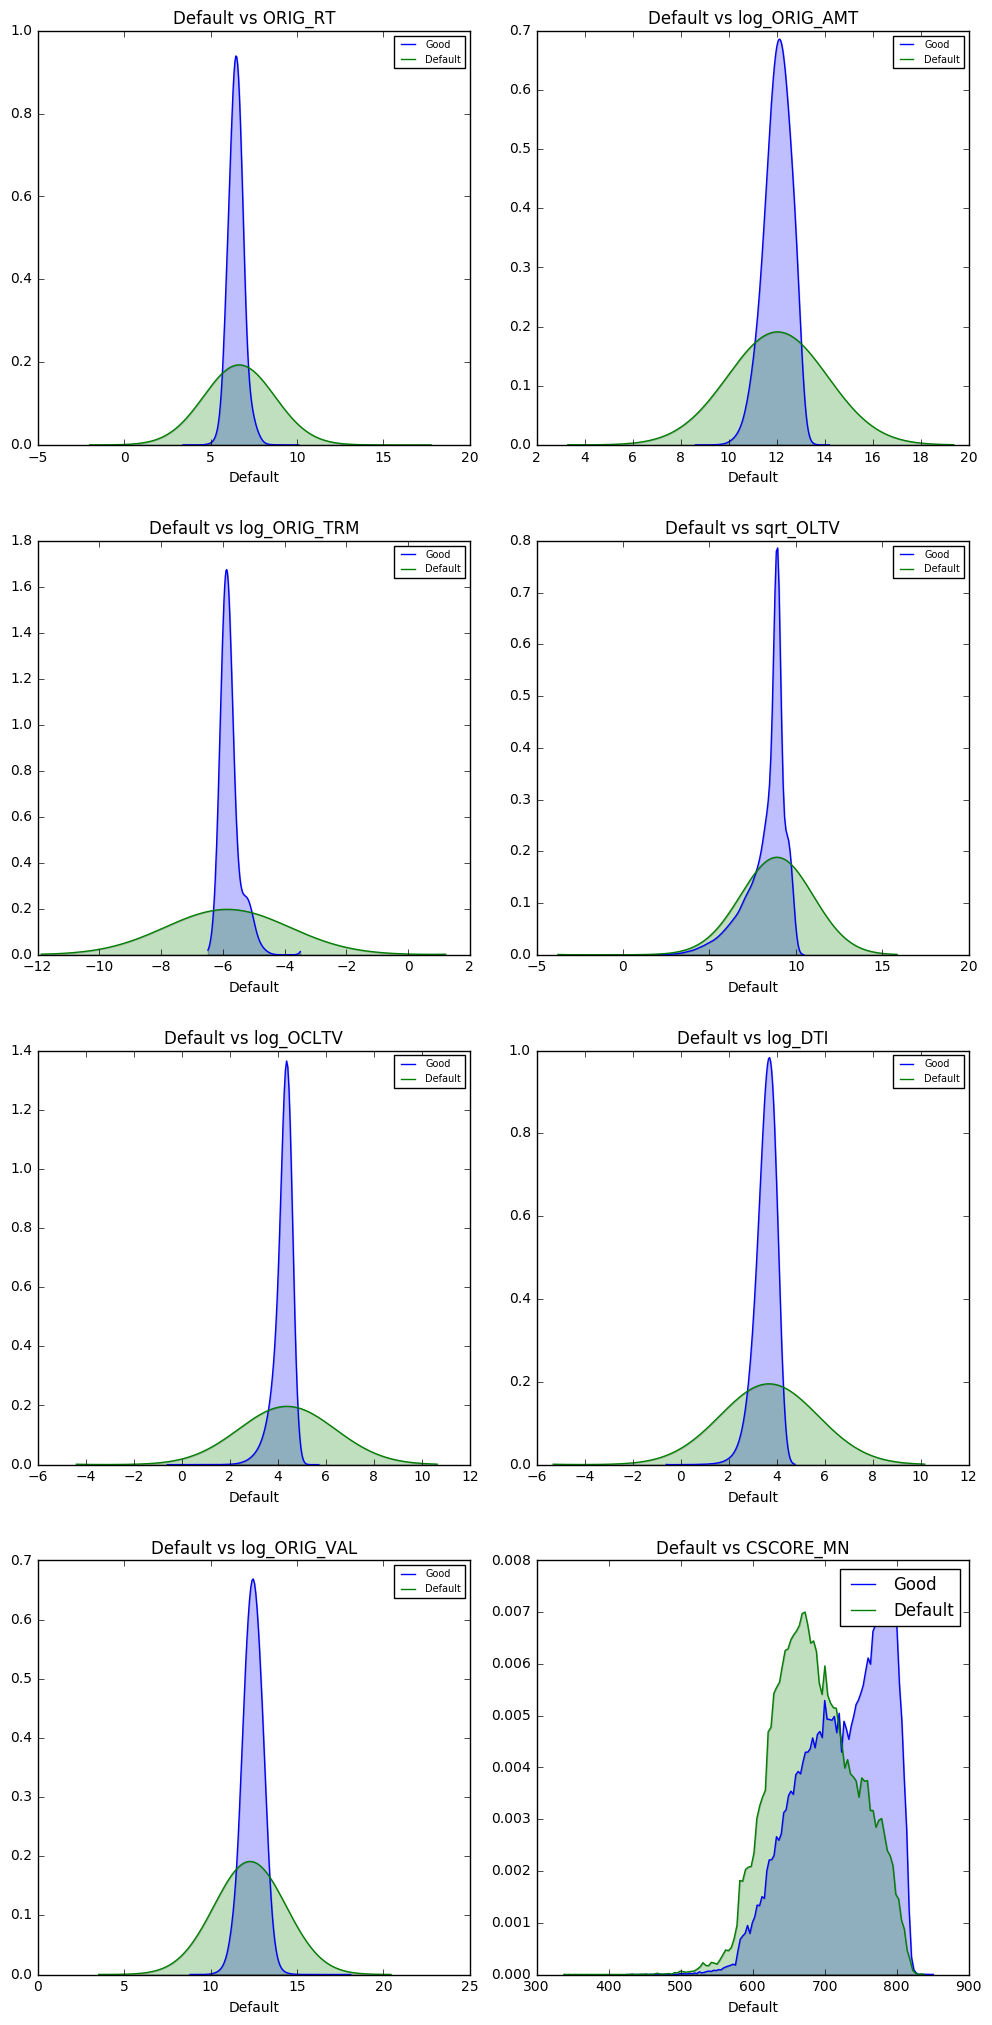

In [44]:
columns = ["ORIG_RT","log_ORIG_AMT","log_ORIG_TRM","sqrt_OLTV","log_OCLTV","log_DTI","log_ORIG_VAL","CSCORE_MN"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,20))
plt.tight_layout(w_pad=2.0, h_pad=5.0)

for i, column in zip(range(1,9), columns):
    plt.subplot(4,2,i)
    p1=sns.kdeplot(Combined_Data[Combined_Data['Default']==0][column], bw=.2, label="Good",shade=True)
    p2=sns.kdeplot(Combined_Data[Combined_Data['Default']==1][column], bw=2, label="Default",shade=True)

    p1.set_title("Default vs "+column)
    plt.legend(loc="upper right", prop={'size': 7})
    plt.xlabel('Default')
plt.legend()

In [45]:
df=Combined_Data.groupby(['STATE','Default']).size()
df2=df.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).reset_index()
df2=df2[df2['Default']==1].sort_values(by=[0],ascending=False)

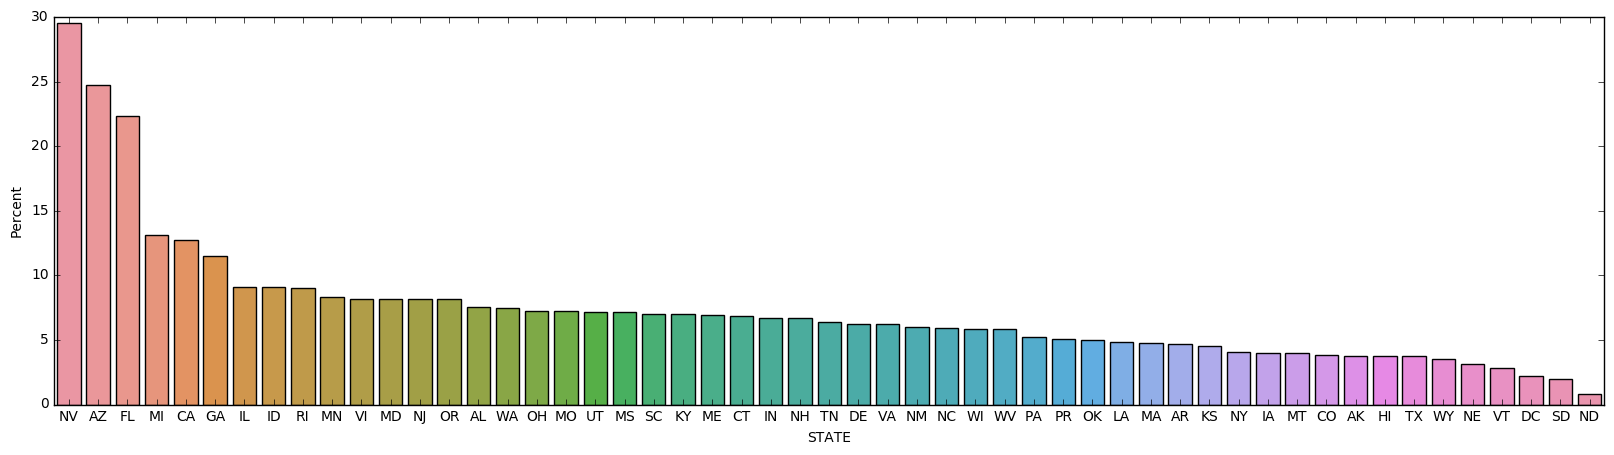

In [46]:
f, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(x="STATE",y=0, data=df2)
ax.set(ylabel="Percent")

In [47]:
# columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE",
#            "NUM_UNIT","PROP_TYP","STATE","ZIP_3",'RELOCATION_FLG','OCC_STAT']

# columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE",
#            "NUM_UNIT","PROP_TYP","STATE","ZIP_3",'RELOCATION_FLG','OCC_STAT',
#            "ORIG_DTE_month","FRST_DTE_year","FRST_DTE_month",'VinYr']

# columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE",
#            "NUM_UNIT","PROP_TYP","STATE",'RELOCATION_FLG','OCC_STAT',
#            "ORIG_DTE_month","FRST_DTE_year","FRST_DTE_month",'VinYr']

columns = ["ORIG_CHN","Seller.Name","NUM_BO","FTHB_FLG","PURPOSE",
            "NUM_UNIT","PROP_TYP","STATE",'RELOCATION_FLG','OCC_STAT']
for column in columns:
    temp=pd.get_dummies(Combined_Data[column],prefix=column,drop_first =True)
    Combined_Data = pd.concat([Combined_Data,temp],axis=1)
    Combined_Data = Combined_Data.drop([column], axis=1)

In [48]:
# final drop
# columns=["ORIG_DTE_month","FRST_DTE_year","FRST_DTE_month",'VinYr',
#           'ORIG_AMT', 'ORIG_TRM', 'OLTV', 'OCLTV', 'DTI','ORIG_VAL']

# columns=['ORIG_AMT', 'ORIG_TRM', 'OLTV', 'OCLTV', 'DTI','ORIG_VAL']
columns=['ORIG_AMT', 'ORIG_TRM', 'OLTV', 'OCLTV', 'DTI','ORIG_VAL','ZIP_3','Zero.Bal.Code','DISP_DT','Delq.Status']

Combined_Data.drop(columns, axis=1, inplace=True)

In [49]:
Combined_Data.columns[:30]

Index(['ORIG_RT', 'CSCORE_MN', 'Default', 'log_ORIG_VAL', 'log_ORIG_AMT',
       'sqrt_OLTV', 'log_ORIG_TRM', 'log_OCLTV', 'log_DTI', 'ORIG_CHN_C',
       'ORIG_CHN_R', 'Seller.Name_BANK OF AMERICA, N.A.',
       'Seller.Name_BISHOPS GATE RESIDENTIAL MORTGAGE TRUST',
       'Seller.Name_CITIMORTGAGE, INC.',
       'Seller.Name_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB',
       'Seller.Name_FIRST TENNESSEE BANK NATIONAL ASSOCIATION',
       'Seller.Name_FLAGSTAR CAPITAL MARKETS CORPORATION',
       'Seller.Name_GMAC MORTGAGE, LLC',
       'Seller.Name_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION',
       'Seller.Name_OTHER', 'Seller.Name_PNC BANK, N.A.',
       'Seller.Name_SUNTRUST MORTGAGE INC.',
       'Seller.Name_WELLS FARGO BANK, N.A.', 'NUM_BO_10.0', 'NUM_BO_2.0',
       'NUM_BO_3.0', 'NUM_BO_4.0', 'NUM_BO_5.0', 'NUM_BO_6.0', 'NUM_BO_7.0'],
      dtype='object')

# Prediction

In [15]:
y = Combined_Data['Default'].values
X = Combined_Data.drop(['Default'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0,stratify=y)

In [27]:
model = xgb.XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4,
    scale_pos_weight=4.5,
    seed=27,
    max_depth = 5,
    min_child_weight = 5
)

def evalauc(preds, dtrain):
    labels = dtrain.get_label()
    precision, recall, thresholds = precision_recall_curve(labels, preds)
    area = auc(recall, precision)
    return 'roc', -area

# def evalauc(y,t):
#     t = t.get_label()
#     y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y] # binaryzing your output
#     return 'f1',f1_score(t,y_bin)

#model.fit(X_resampled, y_resampled)
model.fit(X_train, y_train,
          eval_metric=evalauc,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=5,
         verbose=True) 


[0]	validation_0-error:0.229664	validation_1-error:0.229795	validation_0-roc:-0.262125	validation_1-roc:-0.254519
Multiple eval metrics have been passed: 'validation_1-roc' will be used for early stopping.

Will train until validation_1-roc hasn't improved in 5 rounds.
[1]	validation_0-error:0.158397	validation_1-error:0.159292	validation_0-roc:-0.283275	validation_1-roc:-0.275703
[2]	validation_0-error:0.152878	validation_1-error:0.153108	validation_0-roc:-0.298737	validation_1-roc:-0.292327
[3]	validation_0-error:0.149831	validation_1-error:0.149435	validation_0-roc:-0.303857	validation_1-roc:-0.296008
[4]	validation_0-error:0.151185	validation_1-error:0.150518	validation_0-roc:-0.3148	validation_1-roc:-0.307318
[5]	validation_0-error:0.146802	validation_1-error:0.147006	validation_0-roc:-0.319418	validation_1-roc:-0.31041
[6]	validation_0-error:0.151009	validation_1-error:0.151243	validation_0-roc:-0.31999	validation_1-roc:-0.311962
[7]	validation_0-error:0.154763	validation_1-error

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=4.5, seed=27,
       silent=True, subsample=0.8)

In [28]:
predict = model.predict(X_test)
print(classification_report(y_test, predict))
print(confusion_matrix(y_test,predict))
print(accuracy_score(y_test,predict))

             precision    recall  f1-score   support

          0       0.95      0.87      0.90     77808
          1       0.33      0.57      0.42      9039

avg / total       0.88      0.84      0.85     86847

[[67406 10402]
 [ 3866  5173]]
0.835711078103


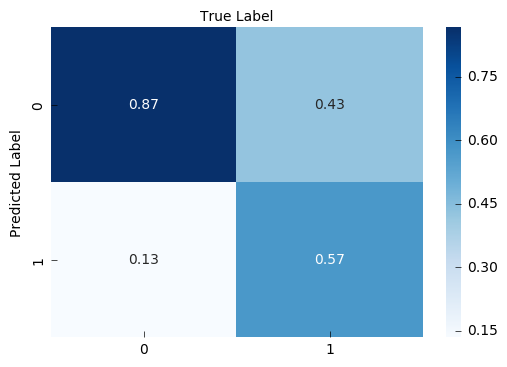

In [30]:
cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')

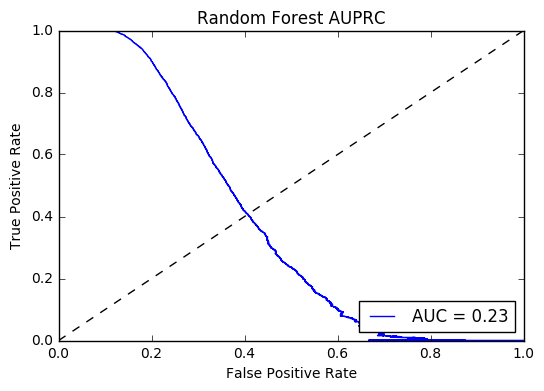

In [31]:
fpr, tpr, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = average_precision_score(y_test, predict)

plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest AUPRC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

## predict other dataset

In [50]:
y = Combined_Data['Default'].values
X = Combined_Data.drop(['Default'], axis=1).values

In [52]:
predict = model.predict(X)
print(classification_report(y, predict))
print(confusion_matrix(y,predict))
print(accuracy_score(y,predict))

             precision    recall  f1-score   support

          0       0.96      0.81      0.88    257319
          1       0.24      0.62      0.34     24717

avg / total       0.89      0.79      0.83    282036

[[207614  49705]
 [  9440  15277]]
0.790292728588


In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, average_precision_score,f1_score,fbeta_score,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split,StratifiedKFold

In [23]:
def fillnan(df):
    columns = df.columns[df.isnull().any()]
    for name in columns:
        y = df.loc[df[name].notnull(), name].values
        X = df.loc[df[name].notnull()].drop(columns, axis=1).values
        X_test = df.loc[df[name].isnull()].drop(columns, axis=1).values
        if df[name].dtypes == 'object':
            model = RandomForestClassifier(n_estimators=10, max_depth=3)
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
        else:
            model = RandomForestRegressor(n_estimators=10, max_depth=3)
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
    return df

In [24]:
Combined_Data2 = fillnan(Combined_Data)

In [32]:
Combined_Data.columns[:30]

Index(['ORIG_RT', 'CSCORE_MN', 'Default', 'log_ORIG_VAL', 'log_ORIG_AMT',
       'sqrt_OLTV', 'log_ORIG_TRM', 'log_OCLTV', 'log_DTI', 'ORIG_CHN_C',
       'ORIG_CHN_R', 'Seller.Name_BANK OF AMERICA, N.A.',
       'Seller.Name_BISHOPS GATE RESIDENTIAL MORTGAGE TRUST',
       'Seller.Name_CITIMORTGAGE, INC.',
       'Seller.Name_FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB',
       'Seller.Name_FIRST TENNESSEE BANK NATIONAL ASSOCIATION',
       'Seller.Name_FLAGSTAR CAPITAL MARKETS CORPORATION',
       'Seller.Name_GMAC MORTGAGE, LLC',
       'Seller.Name_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION',
       'Seller.Name_OTHER', 'Seller.Name_PNC BANK, N.A.',
       'Seller.Name_SUNTRUST MORTGAGE INC.',
       'Seller.Name_WELLS FARGO BANK, N.A.', 'NUM_BO_10.0', 'NUM_BO_2.0',
       'NUM_BO_3.0', 'NUM_BO_4.0', 'NUM_BO_5.0', 'NUM_BO_6.0', 'NUM_BO_7.0'],
      dtype='object')

In [25]:
X=Combined_Data2.iloc[:,Combined_Data2.columns != 'Default'].as_matrix()
y=Combined_Data2['Default'].as_matrix()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y

In [27]:
layers=(10,10,10,10)
learning_rate_init=0.001
alpha=0.0001

#clf = MLPClassifier(solver='adam',activation='tanh',hidden_layer_sizes=layers, learning_rate='adaptive',learning_rate_init=lr_init,alpha=alpha,random_state=2)
clf = MLPClassifier(solver='adam',activation='tanh',
                    hidden_layer_sizes=layers, learning_rate='adaptive',
                    learning_rate_init=learning_rate_init,alpha=alpha,random_state=2345,
                    max_iter=200,verbose=10)

In [28]:
scorings ='average_precision'
fold=5
cv=StratifiedKFold(n_splits=fold,random_state=1234)

scores=cross_validate(clf,X_train,y_train,cv=cv,scoring=scorings,return_train_score=True)
print(scores)

Iteration 1, loss = 0.27121412
Iteration 2, loss = 0.26808400
Iteration 3, loss = 0.26807694
Iteration 4, loss = 0.26807722
Iteration 5, loss = 0.26806563
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.27118640
Iteration 2, loss = 0.26809932
Iteration 3, loss = 0.26808968
Iteration 4, loss = 0.26807007
Iteration 5, loss = 0.26807442
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.27121781
Iteration 2, loss = 0.26806039
Iteration 3, loss = 0.26811043
Iteration 4, loss = 0.26808761
Iteration 5, loss = 0.26807290
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.27111727
Iteration 2, loss = 0.26807990
Iteration 3, loss = 0.26809324
Iteration 4, loss = 0.26806681
Iteration 5, loss = 0.26808593
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, los

In [36]:
Combined_Data['log_ORIG_VAL']=np.log(Combined_Data['ORIG_VAL'])

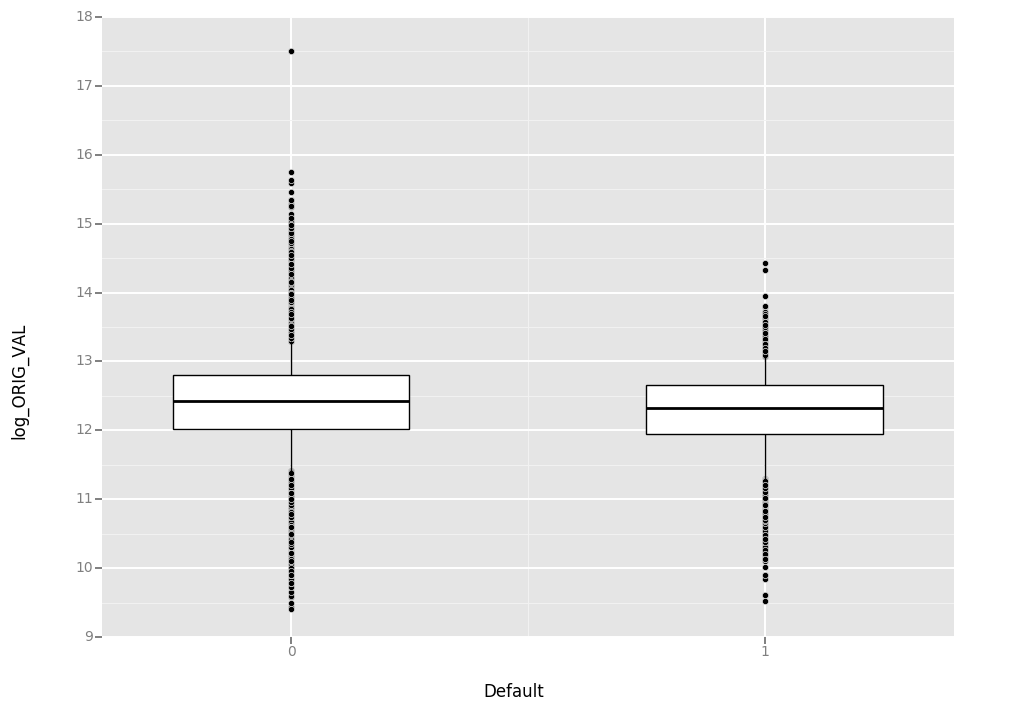

<ggplot: (134801002465)>

In [30]:
ggplot(aes(x='Default',y='log_ORIG_VAL'),data=Combined_Data)+geom_boxplot()

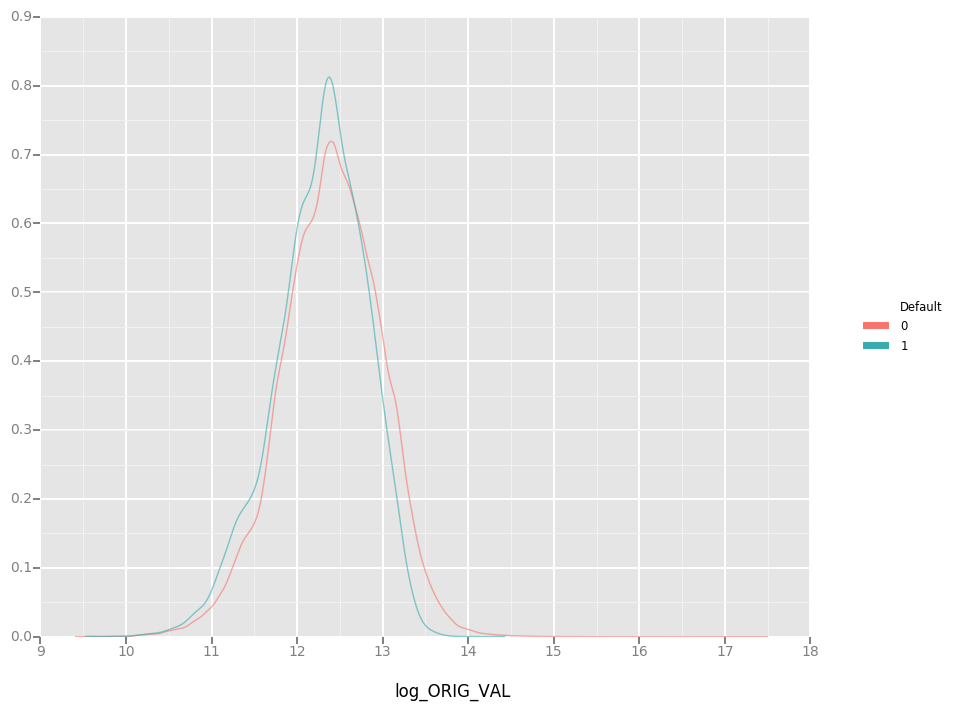

<ggplot: (-9223371901831369910)>

In [62]:
ggplot(aes(x='log_ORIG_VAL',color='Default'),data=Combined_Data)+ \
geom_density(alpha=0.6)

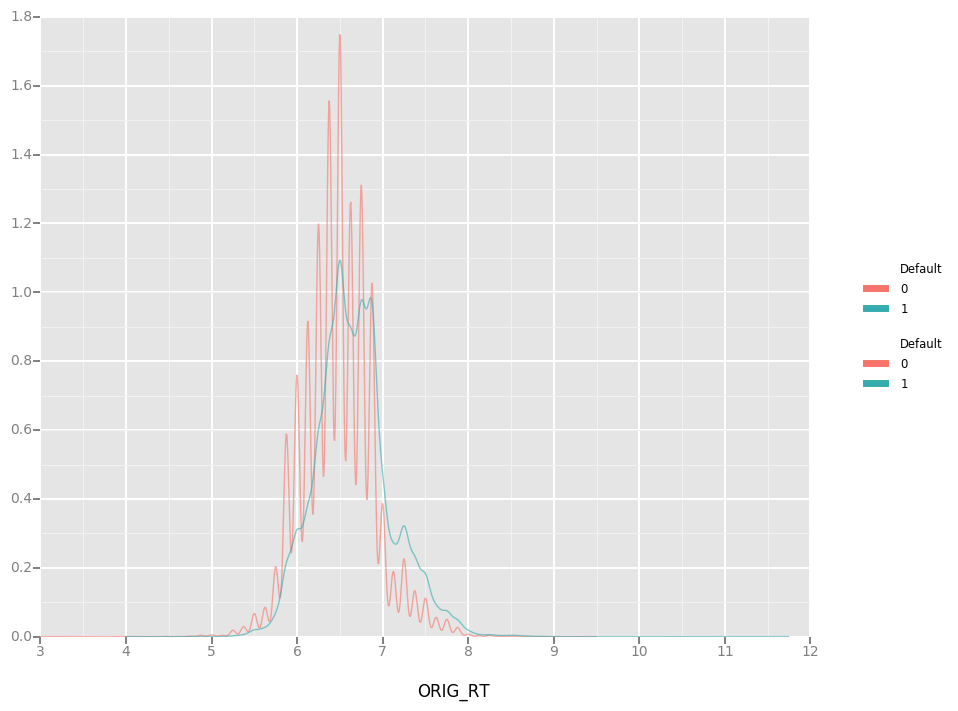

<ggplot: (-9223371902089763924)>

In [41]:
ggplot(aes(x='ORIG_RT',color='Default',fill='Default'),data=Combined_Data)+ \
geom_density(alpha=0.6)

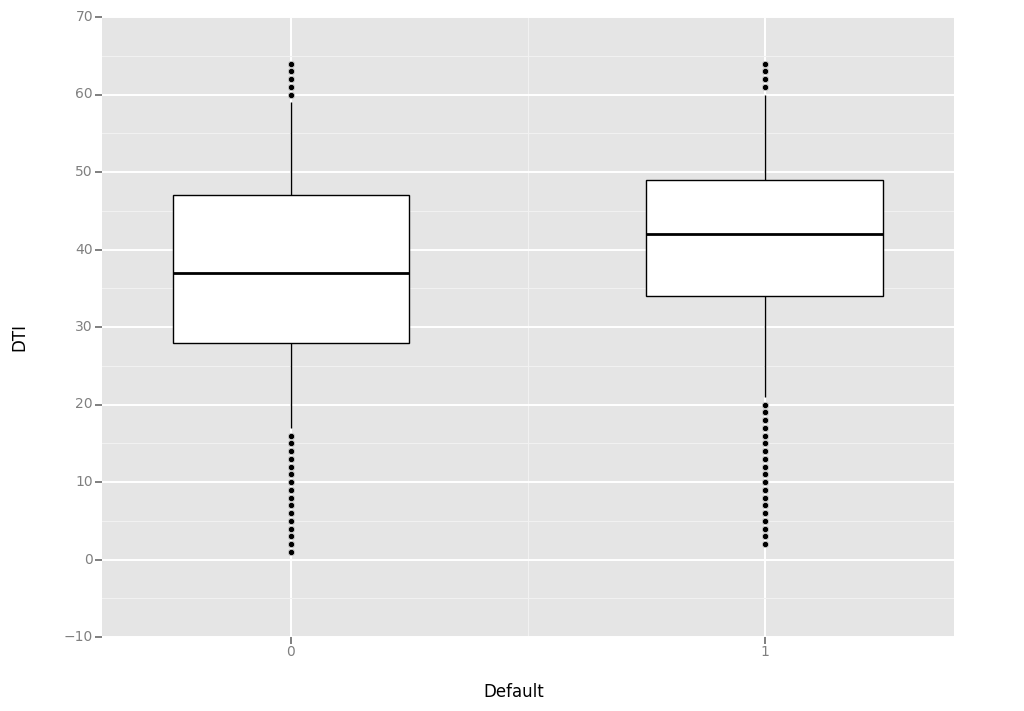

<ggplot: (135007511360)>

In [60]:
ggplot(aes(x='Default',y='DTI'),data=Combined_Data[Combined_Data['DTI'].notnull()])+geom_boxplot()

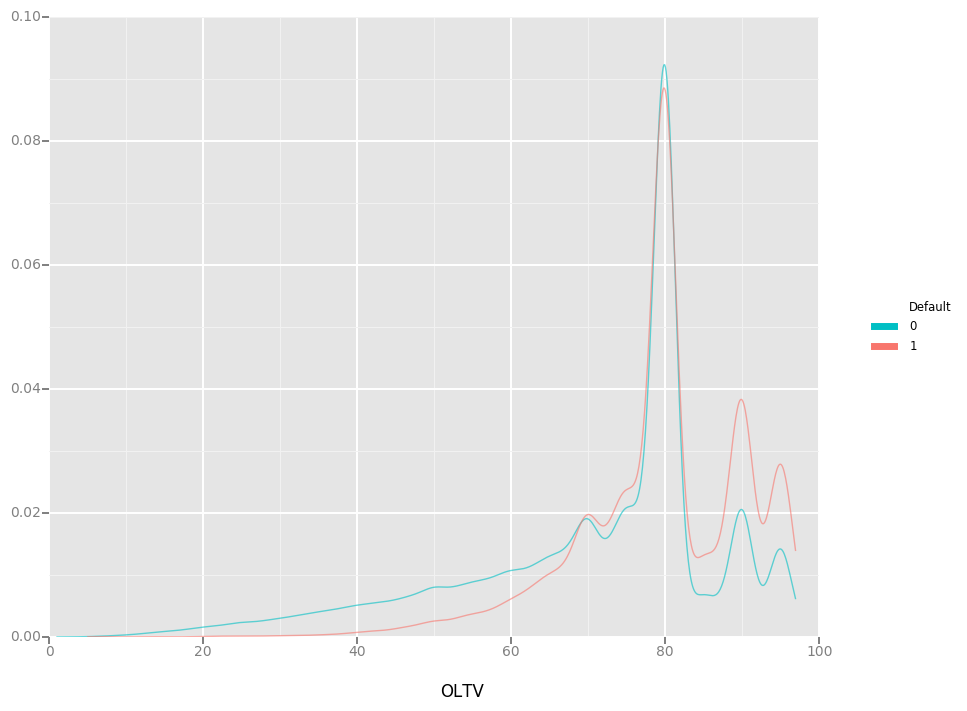

<ggplot: (134961319039)>

In [54]:
ggplot(aes(x='OLTV',color='Default'),data=Combined_Data)+ \
geom_density(alpha=0.6)+ \
scale_color_manual(values = ["#00BFC4","#F8766D"])

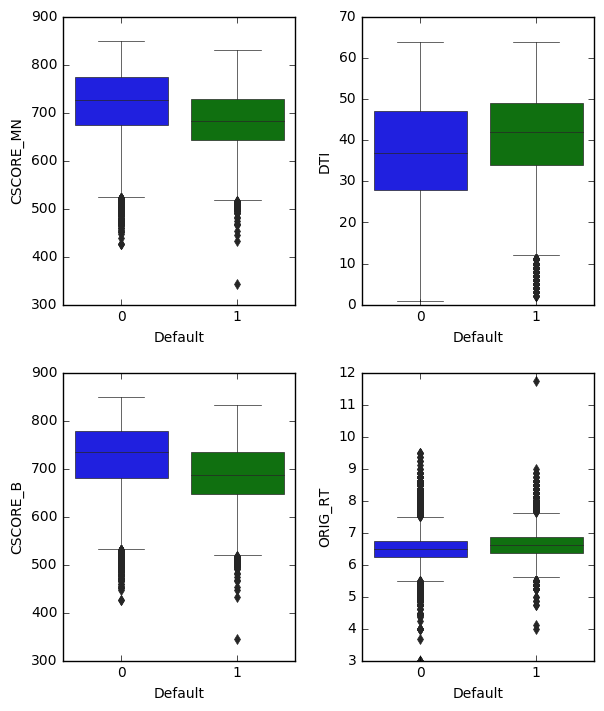

In [19]:
columns = ['CSCORE_MN','DTI','CSCORE_B','ORIG_RT']

fig, axes = mp.subplots(nrows=2, ncols=2, figsize=(6,7))
mp.tight_layout(w_pad=2.0, h_pad=3.0)

for i, column in zip(range(1,5), columns):
    mp.subplot(2,2,i)
    sns.boxplot(x="Default", y=column, data=Combined_Data, linewidth=0.5)
    mp.xlabel('Default')

1.0     306593
NaN      43821
9.0      24921
3.0       8583
6.0       3363
2.0       1493
16.0      1277
15.0      1158
Name: Zero.Bal.Code, dtype: int64

In [8]:
Combined_Data['Default']=Combined_Data['FCC_DTE'].apply(lambda x: 0 if str(x)=='NaT' else 1).astype(int)
Combined_Data['Default'].value_counts(dropna=False)

0    356416
1     34793
Name: Default, dtype: int64

In [21]:
Combined_Data[Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0'])]['FCC_DTE'].shape

(36155,)

In [25]:
Combined_Data[Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0']) 
              & Combined_Data['DISP_DT'].notnull()]['FCC_DTE'].shape

(35408,)

In [27]:
Combined_Data[Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0']) 
              & Combined_Data['DISP_DT'].notnull() & Combined_Data['FCC_DTE'].notnull()].shape

(34182, 56)

In [28]:
Combined_Data[Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0']) 
              & Combined_Data['DISP_DT'].notnull() & Combined_Data['FCC_DTE'].notnull()].shape

(34182, 56)

In [61]:
Combined_Data[ (~Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0'])) 
               & Combined_Data['ZB_DTE'].notnull()].shape

(311233, 56)

In [59]:
Combined_Data[ (~Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0']))].shape

(355054, 56)

In [70]:
Combined_Data[ (~Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0']))]['Delq.Status'].value_counts(dropna=False)


X      311233
0       36598
1        3178
2        1061
3         656
4         394
5         216
6         163
7         127
8         111
9         105
10         87
11         68
12         67
13         59
15         50
14         49
16         49
18         37
22         34
17         34
19         29
20         28
25         25
21         20
28         20
23         18
26         17
24         16
29         15
        ...  
79          4
72          4
78          4
59          4
50          3
105         3
102         3
62          3
95          3
111         3
106         3
52          2
121         2
63          2
83          2
114         2
38          2
46          2
116         2
45          2
84          2
86          2
115         2
98          1
108         1
118         1
99          1
112         1
117         1
75          1
Name: Delq.Status, dtype: int64

In [77]:
import datetime
Combined_Data[ (~Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0'])) &
             (Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0'])
             )].shape


(1504, 56)

In [81]:
Combined_Data[ (~Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0'])) &
             (Combined_Data['Zero.Bal.Code'].isin(['6.0','1.0','16.0']))].shape

(311233, 56)

In [82]:
Combined_Data[ (~Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0'])) &
             (Combined_Data['Zero.Bal.Code'].isin(['6.0','1.0','16.0']))]['Delq.Status'].value_counts(dropna=False)

X    311233
Name: Delq.Status, dtype: int64

In [84]:
Combined_Data[ (~Combined_Data['Zero.Bal.Code'].isin(['2.0','3.0','9.0','15.0'])) &
             (Combined_Data['Zero.Bal.Code'].isnull())]['Delq.Status'].value_counts(dropna=False)

0      36598
1       3178
2       1061
3        656
4        394
5        216
6        163
7        127
8        111
9        105
10        87
11        68
12        67
13        59
15        50
16        49
14        49
18        37
22        34
17        34
19        29
20        28
25        25
21        20
28        20
23        18
26        17
24        16
29        15
27        13
       ...  
73         4
72         4
61         4
85         4
106        3
105        3
95         3
102        3
50         3
62         3
111        3
115        2
46         2
86         2
38         2
116        2
63         2
83         2
114        2
52         2
45         2
121        2
84         2
98         1
108        1
112        1
75         1
117        1
99         1
118        1
Name: Delq.Status, dtype: int64

In [73]:
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()
zipcode = search.by_prefix("002")
print(zipcode)

[]


In [19]:
for i in zipcode:
    print(i.Latitude)

29.130030699999995
29.463300800000003
29.4040686
29.392885600000003
29.198795699999998


In [49]:
res = search.by_coordinate(39.122229, -77.133578, radius=99999, returns=99999)

zip_list=[]
for i in res:
    zip_list.append({'Zipcode': i.Zipcode,'Latitude': i.Latitude,'Longitude':i.Longitude,'ZIP_3':i.Zipcode[:3]})

df=pd.DataFrame.from_dict(zip_list)

df1=df.groupby(['ZIP_3']).mean().reset_index()


Combined_Data=pd.merge(Combined_Data,df1,on='ZIP_3', how='inner')

Combined_Data[Combined_Data.Longitude]